Group name: Explanation is All You Need

# Explaining Text Classifiers

Our goal is to explain the prediction of a text classifier, detecting which part of the input text is responsible of a given prediction. For that we used SST-2 (Stanford Sentiment Treebank 2) dataset which consists of text and sentiment label pairs where the label 0 indicates negative sentiment 1 indicates positive sentiment.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

import datasets
import string 
from collections import Counter

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F

from load_glove import load_file, construct_embedding

from ipywidgets import interact

## The dataset

We used SST-2, a sentiment anlysis dataset which contains thousands of text/sentiment pairs.

In [2]:
sst2_dataset = datasets.load_dataset('glue', 'sst2')

Reusing dataset glue (C:\Users\urchade\.cache\huggingface\datasets\glue\sst2\1.0.0\7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4)


In [3]:
labels = sst2_dataset['train']['label']
texts = sst2_dataset['train']['sentence']

The dataset contains 29780 negative texts and 37569 positives.

In [4]:
Counter(labels)

Counter({0: 29780, 1: 37569})

## Preprocessing

### Tokenization

In [5]:
def tokenize(text: str):
    """Tokenize a text by removing punctuation"""
    
    text = text.lower().split()
        
    return [t.strip(string.punctuation) for t in text if t not in string.punctuation]

In [8]:
# Tokenization example

tokenize('I/ am happy , .')

['i', 'am', 'happy']

### Vocabulary construction

In [9]:
### List of all tokens from the dataset
all_tokens = [tokens for sent in texts for tokens in tokenize(sent)]

# count tokens
token_counts = Counter(all_tokens)

# The most common words are the, a, and ... etc
token_counts.most_common()[:5]

[('the', 27205), ('a', 21609), ('and', 19920), ('of', 17907), ('to', 12538)]

In [10]:
# Here we create our vocabulary

min_freq = 3

vocab = [a[0] for a in list(filter(lambda x: x[1] >= min_freq, token_counts.most_common()))]

print(vocab[:10])

['the', 'a', 'and', 'of', 'to', 's', 'is', 'that', 'in', 'it']


In [11]:
# Add a padding token and a UNK token to our vocabulary

pad_token = '[PAD]'
unk_token = '[UNK]'

vocab.insert(0, pad_token)
vocab.insert(1, unk_token)

print(vocab[:5])

['[PAD]', '[UNK]', 'the', 'a', 'and']


In [12]:
id2word = dict(enumerate(vocab)) # a dict that map an Id to a word
word2id = {v:k for (k, v) in id2word.items()} # inverse mapping

print(f"man => {word2id['man']}")

man => 206


In [13]:
print(f'there is {len(vocab)} unique tokens in the vocabulary')

there is 13481 unique tokens in the vocabulary


### Text to sequence of IDs

In [14]:
def sent2ids(text: str):
    """Convert a text to a sequence of IDs"""
    sent = []
    
    tokens = tokenize(text)
    
    for word in tokens:
        
        try:
            id_w = word2id[word]
            
        except KeyError:
            id_w = word2id['[UNK]']
        
        sent.append(id_w)
        
    return sent

# Example

s = 'the movie was great'
print(f"{s} == > {sent2ids(s)}")

the movie was great == > [2, 19, 93, 96]


### Pre-trained word vectors

In [15]:
# Optionnal: Use pretrained word vectors for better classification results

glove_embedding = None
use_glove = True 

glove_file = 'glove.6B.50d.txt' # download from http://nlp.stanford.edu/data/glove.6B.zip
vect_dim = 50

if use_glove:
    
    # load glove
    glove_vec = load_file(glove_file)
    
    # construct the embedding matrix given id2word
    glove_embedding = construct_embedding(glove_vec, id2word, dim=vect_dim)
    
    # convert the embedding matrix to torch tensor
    glove_embedding = torch.Tensor(glove_embedding)

100%|████████████████████████████████████████████████████████████████████████| 13481/13481 [00:00<00:00, 300377.77it/s]

loaded = 12564/13481


### Pytorch Dataset

In [16]:
class TextDataset(Dataset):
    
    def __init__(self, texts: list, labels: list):
        
        self.labels = labels
        self.texts = texts
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        
        x = sent2ids(self.texts[idx])
        
        y = self.labels[idx]
        
        # handle empty text
        if len(x) == 0:
            return self.__getitem__(np.random.randint(0, len(self)))
        
        return x, y

### Collation

In [17]:
def pad_seq(sequence_list, max_seq):
    
    """Padding/Truncate a list of sequences to max_seq"""
    
    max_batch = max([s.shape[0] for s in sequence_list])
    
    result = np.zeros((len(sequence_list), max_batch))
    
    for i in range(len(sequence_list)):
        
        array_i = sequence_list[i]

        dim_1 = array_i.shape[0]
        
        result[i, :dim_1] += array_i
        
    if max_batch > max_seq:
        result = result[:, :max_seq]
    
    return torch.LongTensor(result)


def collate(batch):
        
    src = pad_seq([np.array(item[0]) for item in batch], max_seq=50)
        
    y = torch.FloatTensor([item[1] for item in batch])
        
    return [src, y]

### Data splitting and DataLoaders

In [18]:
config = {
    'train_bs': 1024,
    'val_bs': 128,
    'val_size': 5000,
}


dataset = TextDataset(texts, labels)

train, val = random_split(dataset, [len(dataset)-config['val_size'], config['val_size']])

loader = DataLoader(train, config['train_bs'], True, collate_fn=collate, drop_last=True)

val_load = DataLoader(val, config['val_bs'], False, collate_fn=collate)

## Models architecture

### Encoders

In [20]:
## Simple encoder: Embedding layer + mlp

class SimpleEncoder(nn.Module):    
    def __init__(self, n_words: int, emb_dim: int, hidden_dim: int, embedding_weight: torch.Tensor=None):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(n_words, emb_dim, padding_idx=0, _weight=embedding_weight)
        
        # Multi-Layer Perceptron
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
    def forward(self, x: torch.LongTensor):
        """
        x: input IDs of shape [batch_size, seq_len]
        """
                
        out = self.embedding(x) # [batch_size, seq_len, emb_dim]
        
        return self.mlp(out) # [batch_size, seq_len, hidden_dim]

In [21]:
## RNN encoder: Embedding layer + Bi-LSTM

class RnnEncoder(nn.Module):
    
    def __init__(self, n_words: int, emb_dim: int, hidden_dim: int, embedding_weight: torch.Tensor=None):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(n_words, emb_dim, padding_idx=0, _weight=embedding_weight)
        
        # Bi-LSTM Layer
        self.rnn = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        
        # Projection
        self.W = nn.Linear(hidden_dim*2, hidden_dim)
        
    def forward(self, x: torch.LongTensor):
        """
        x: input IDs of shape [batch_size, seq_len]
        """
        
        bs, max_len = x.size()
        
        lens = (x != 0).sum(1).cpu()
                
        embs = self.embedding(x) # [batch_size, seq_len, emb_dim]
            
        packed = nn.utils.rnn.pack_padded_sequence(embs, lens, batch_first=True, enforce_sorted=False)
        
        out_packed, *_ = self.rnn(packed)
        
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        
        return self.W(unpacked) # [batch_size, seq_len, hidden_dim]

### Attention Layer

We employ the scaled dot product attention (Vaswani et al., 2017):

<img src="images/dot_prod_att.PNG" width="300" />

In [22]:
# Attention layer

class DotProductAttention(nn.Module):
    def __init__(self, dim: int):
        
        super().__init__()
        
        self.dim = dim
        
        # Parameter: Query vector 
        self.query = nn.Parameter(data=torch.randn(1, self.dim))
        
        # Key Linear Transform
        self.Wk = nn.Linear(self.dim, self.dim, bias=False)
        
        # Value Linear Transform
        self.Wv = nn.Linear(self.dim, self.dim, bias=False)
        
    def forward(self, hidden: torch.Tensor, mask: torch.BoolTensor=None):
        """
        hidden: Tokens representations of shape [batch_size, seq_len, dim]
        mask: Attention mask of shape [batch_size, seq_len]
        """
        
        bs, *_ = hidden.size()
        
        # key tensor
        key = self.Wk(hidden) # [batch_size, seq_len, dim]
        
        # value
        value = self.Wv(hidden) # [batch_size, seq_len, dim]
        
        # query
        query = self.query.expand(bs, self.dim).reshape(bs, self.dim, 1) # [batch_size, dim, 1]
        
        score = torch.bmm(key, query) # [batch_size, seq_len, 1]
        
        score /= np.sqrt(self.dim) # scale 
        
        if mask is not None:
            score = score.masked_fill(mask.reshape(score.shape), float('-inf'))
            
        attention = torch.softmax(score, dim = 1) # [batch_size, seq_len, 1]
        
        output = attention * value # [batch_size, seq_len, dim]
        
        return output, attention

### Text classifier

In [23]:
# Text classifier: Encoder + Attention Layer + Fully connected Layers

class AttentionClassifier(nn.Module):
    
    def __init__(self, n_words: int, emb_dim: int, hidden_dim: int, encoder: str='simple', embedding_weight: torch.Tensor=None):
        super().__init__()
        
        if encoder == 'rnn':
            self.encode = RnnEncoder(n_words, emb_dim, hidden_dim, embedding_weight)
        elif encoder == 'simple':
            self.encode = SimpleEncoder(n_words, emb_dim, hidden_dim, embedding_weight)
        
        self.attention_layer = DotProductAttention(hidden_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, mask=None):
        """
        x: Input Ids of shape [batch_size, seq_len]
        mask: Attention mask of shape [batch_size, seq_len]
        """
        
        encoded_sequence = self.encode(x) # [batch_size, hidden_dim]
        
        out, attention_score = self.attention_layer(encoded_sequence, mask)
        
        out = out.mean(1) # [batch_size, hidden_dim]
        
        y = self.fc(out) # [batch_size, 1]
        
        return y, attention_score # output the prediction and attention weight
    
    def compute_loss(self, x: torch.LongTensor, y: torch.FloatTensor, mask: torch.BoolTensor=None):
        """
        Compute the binary cross-entropy loss
        
        x: Input Ids of shape [batch_size, seq_len]
        y: Labels of shape [batch_size]
        mask: Attention mask of shape [batch_size, seq_len]
        """
        y_, attention_score = self.forward(x, mask)
        
        loss = F.binary_cross_entropy(y_.squeeze(), y)
        
        return loss, self.accuracy(y_, y) # return the loss and accuracy
    
    @torch.no_grad()
    def accuracy(self, y_, y):
        
        y_ = (y_.squeeze() > 0.5).float()
        
        return (y == y_).float().mean()

The model is similar to this one from (Wiegreffe and Pinter, 2019):

  <img src="images/model.PNG" width="500" />

In [25]:
device = 'cpu'

if torch.cuda.is_available():
    device = 'cuda'

model = AttentionClassifier(n_words=len(vocab), emb_dim=50, hidden_dim=64,
                           encoder='simple',
                           embedding_weight=glove_embedding).to(device)

optimizer = torch.optim.AdamW(model.parameters())

In [26]:
n_epochs = 10

val_acc_ = [0]

for ep in range(n_epochs):
    
    pbar = tqdm(enumerate(loader), leave=None)
    
    model.train()
    
    acc_ = []
    
    for i, (x, y) in pbar:

        optimizer.zero_grad()
        
        m = x==0
        
        x, y, m = x.to(device), y.to(device), m.to(device)

        loss, acc = model.compute_loss(x, y, m)

        loss.backward()

        optimizer.step()
        
        acc_.append(acc.item())
        
        pbar.set_description(f"{ep} || Train_loss = {loss.item(): .3f} || Train_acc = {np.array(acc_).mean(): .3} || Valid_acc = {np.array(val_acc_).mean(): .3f}")
        
    with torch.no_grad():
        model.eval()
        
        val_acc_ = []
        
        for x, y in val_load:
            
            m = x==0
            
            x, y, m = x.to(device), y.to(device), m.to(device)

            loss, acc = model.compute_loss(x, y, m)
            
            val_acc_.append(acc.item())
        
        if ep == n_epochs-1:
            print(f"Final validation accuracy = {np.array(val_acc_).mean(): .3f}")

0 || Train_loss =  0.580 || Train_acc =  0.545 || Valid_acc =  0.000: : 60it [00:06,  9.37it/s]
1 || Train_loss =  0.380 || Train_acc =  0.811 || Valid_acc =  0.717: : 60it [00:05, 10.97it/s]
2 || Train_loss =  0.252 || Train_acc =  0.877 || Valid_acc =  0.859: : 60it [00:04, 12.91it/s]
3 || Train_loss =  0.252 || Train_acc =  0.904 || Valid_acc =  0.891: : 60it [00:04, 12.67it/s]
4 || Train_loss =  0.193 || Train_acc =  0.92 || Valid_acc =  0.892: : 60it [00:04, 13.04it/s] 
5 || Train_loss =  0.172 || Train_acc =  0.931 || Valid_acc =  0.912: : 60it [00:05, 11.38it/s]
6 || Train_loss =  0.149 || Train_acc =  0.938 || Valid_acc =  0.915: : 60it [00:05, 11.93it/s]
7 || Train_loss =  0.154 || Train_acc =  0.943 || Valid_acc =  0.917: : 60it [00:04, 12.38it/s]
8 || Train_loss =  0.118 || Train_acc =  0.949 || Valid_acc =  0.919: : 60it [00:04, 12.50it/s]
9 || Train_loss =  0.120 || Train_acc =  0.952 || Valid_acc =  0.918: : 60it [00:04, 12.62it/s]


Final validation accuracy =  0.920


# Interpretation

In [27]:
model.eval()
model.cpu()
print('Evaluation mode !')

Evaluation mode !


In [40]:
def transform_text(text: str):
    
    sequence = sent2ids(text.lower())
    
    tokens = []
    
    for word_id in sequence:
        
        word = id2word[word_id]
        
        tokens.append(word)
        
    x = torch.LongTensor(sequence).reshape(1, -1) # convert to torch
    
    return x, tokens

tensor, tokens = transform_text('i hate this movie')

print(f'tensor = {tensor} \ntokens = {tokens}')


# This function returns the prediction and the attention weigths given a sequence
@torch.no_grad()
def predict(sequence: torch.LongTensor, model: nn.Module):
    
    pred, attention = model(sequence)
    
    return pred.item(), attention.squeeze().numpy()

prediction, attention_score = predict(tensor, model)

print(f'attention_score = {attention_score} \nprediction = {prediction}')

tensor = tensor([[  51, 1089,   20,   19]]) 
tokens = ['i', 'hate', 'this', 'movie']
attention_score = [0.03606517 0.9513782  0.00638908 0.00616754] 
prediction = 1.260003756644323e-20


## Attention-based explanation

Our first approach is to explain our model prediction using the attention score produced by the model's attention module. The intuition is that the model will focus on the most important words in order to make his prediction. This approach is widely used in the Deep Learning literature, for example in Neural Machine Translation (Bahdanau et al., 2015) or Natural Language Inference (Parikh et al., 2016). However, the use of attention for explaining Deep Learning models remains controversial (Jain and Wallace, 2019; Wiegreffe and Pinter, 2019).

* Attention is not explanation (Jain and Wallace, 2019)
* Attention is not not explanation (Wiegreffe and Pinter, 2019)


##### Attention for Neural Machine Translation: Image from Bahdanau et al. (2015)


<p align="center">
  <img src="images/bahdanau.PNG" width="300" />
</p>

**Hohman et al.'s human-centered interrogative framework**:

    - Why:
        - Interpretability and explainability
        - Detecting bias in the dataset/model

    - What:
        - The attention weights

    - When:
        - After training

    - Who:
        - Model developers
        - Model Users
        - Non-experts

    - How:
        - Visualize feature importance using saliency maps
        
    - Where:
        - Application domains

In [29]:
# @interact(text='the movie is not bad')
def explain_with_attention(text: str):
    
    model.cpu()
    model.eval() # eval mode
            
    seq_torch, word_sequence = transform_text(text)
    
    pred, attention = predict(seq_torch, model) # prediction + attention weights

    heatmap = pd.DataFrame(data = attention.reshape(1, -1), columns=word_sequence)

    plt.figure(figsize=(20, 2))
    
    sns.heatmap(heatmap, annot=True, yticklabels=False, cmap='Reds')
    
    if pred > 0.5:
        print(f'positive => {pred: 0.3f}')
    
    else:
        print(f'negative => {pred: 0.3f}')

positive =>  1.000


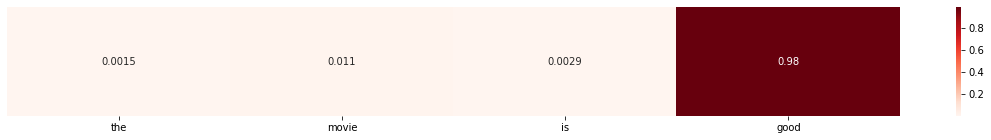

In [30]:
explain_with_attention('the movie is good')

In [31]:
# Here we extract positive/negative words from the validation dataset
# => take the words that has gotten the most attention during a forward pass to model

confidence = 0.9999

positive_words = []
negative_words = []

with torch.no_grad():
    
    model.eval()

    for x, y in val_load:

        m = x==0 # mask
        y_hat, attention_score = model.forward(x, m)
        
        att_word = torch.argmax(attention_score.squeeze(), dim=1)
        
        for a, w, yy in zip(att_word, x, y_hat):
            
            if yy > confidence:
                positive_words.append(id2word[w[a].item()])
                
            elif yy < 1 - confidence:
                negative_words.append(id2word[w[a].item()])

#### positive words: 

In [32]:
# ex: superb brilliant perfectly excellent happiness happiness incredible outstanding tasteful

list(set(positive_words))

['sustains',
 'inimitable',
 'penetrating',
 'playful',
 'admirable',
 'sought',
 'sweet',
 'fantasy',
 'continues',
 'astonishing',
 'broadway',
 'engage',
 'significant',
 'feat',
 'draws',
 'exhilarating',
 'collectively',
 'pearls',
 'panache',
 'valiant',
 'monumental',
 'exotic',
 'intelligently',
 'distinctive',
 'innovators',
 'welcome',
 'strategies',
 'tasteful',
 'laughter',
 'charismatic',
 'clever',
 'manages',
 'superior',
 'craftsmanship',
 'gorgeously',
 'tour',
 'challenges',
 'undoubtedly',
 'right',
 'hopeful',
 'recovery',
 'anchoring',
 'beautifully',
 'professionals',
 'fun',
 'creates',
 'thought-provoking',
 'lyrical',
 'transcendence',
 'portrayal',
 'elusive',
 'incredible',
 'companionship',
 'a-list',
 'edge',
 'stagings',
 'charisma',
 'fearlessness',
 'techniques',
 'exciting',
 'acclaim',
 'thoughtful',
 'goofily',
 'heartfelt',
 'distinguished',
 'pretty',
 'entertaining',
 'sights',
 'righteousness',
 'salton',
 'love',
 'sweetly',
 'production',
 'work

#### negative words: 

In [33]:
# ex: unlikable lifeless poorly pointless stupid absurdly distasteful garbage sexist trash

list(set(negative_words))

['dissing',
 'stealing',
 'choppy',
 'dragged',
 'clichéd',
 'puddle',
 'intolerable',
 'bolt',
 'obscure',
 'poor',
 'irresponsible',
 'insignificance',
 'cheapo',
 'copy',
 'off-putting',
 'haphazard',
 'double-barreled',
 'lifeless',
 'inept',
 'insulting',
 'numbingly',
 'lame',
 'leash',
 'parking',
 'stupid',
 'sordid',
 'absurdly',
 'atrociously',
 'embarrassingly',
 'garbage',
 'schedule',
 'undone',
 'hypocritical',
 'stinker',
 'sociopathy',
 'gang-raped',
 'unfocused',
 'substandard',
 'cheesier',
 'ailments',
 'horribly',
 'maudlin',
 'untalented',
 'ineffective',
 'pileup',
 'deficit',
 'insultingly',
 'pit',
 'unmotivated',
 'sluggish',
 'malaise',
 'irritating',
 'shriveled',
 'sentence',
 'lackluster',
 'bleak',
 'vague',
 'bogus',
 'distanced',
 'mistake',
 'waste',
 'shapeless',
 'foul-mouthed',
 'ludicrous',
 'sabotaged',
 'sickening',
 'embarrassment',
 'toilet',
 'laziness',
 'inevitable',
 'wimps',
 'overplayed',
 'questionable',
 'distasteful',
 'preposterous',
 

## Perturbation-based explanation (leave-one-out)

This approach have been presented by (Wallace et al., 2020) in their tutorial. It is a simple method that defines the importance as a drop in prediction when the feature is removed. The approach is described in the following image from Wallace et al. 'S tutorial slide.

<p align="center">
  <img src="images/leave_one_out.PNG" width="500" />
</p>

**Hohman et al.'s human-centered interrogative framework**:

    - Why:
        - Interpretability and explainability
        - Detecting bias in the dataset/model

    - What:
        - The model's prediction score

    - When:
        - After training

    - Who:
        - Model developers
        - Model Users
        - Non-experts

    - How:
        - Visualize feature importance using saliency maps
        
    - Where:
        - Application domains        

In [34]:
def score_each_word(text: str, model: nn.Module=model):
    
    x, _ = transform_text(text)
    
    score_text, _ = predict(x, model)
    
    var = []
    
    tokens = text.split()
    
    for i in range(len(tokens)):
                
        var.append((tokens[i], ' '.join([w for (k, w) in enumerate(tokens) if k!=i])))
    
    scores = []
    
    for pairs in var:
        
        x, _ = transform_text(pairs[1])
        
        score_w, _ = predict(x, model)
        
        sc = score_text - score_w
        
        scores.append((pairs[0], sc))
        
    return scores, score_text

In [35]:
# @interact(text='the movie is not bad')
def explain_by_perturbation(text: str):
    
    model.cpu()
    model.eval() # eval mode
    
    scores, score_text = score_each_word(text, model)
    
    if score_text > 0.5:
        print(f'positive => {score_text: 0.3f}')
    
    else:
        print(f'negative => {score_text: 0.3f}')
    
    arr = np.array(
        [el[1] for el in scores]
    ).reshape(1, -1)

    y = [el[0] for el in scores]
    
    heatmap = pd.DataFrame(data = arr, columns=y)

    plt.figure(figsize=(20, 2))

    sns.heatmap(heatmap, annot=True, yticklabels=False, cmap='Reds')

negative =>  0.000


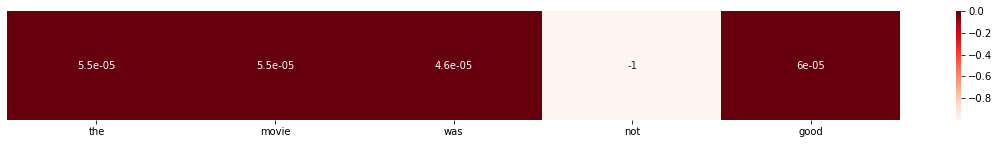

In [36]:
explain_by_perturbation('the movie was not good')

## Gradient-based explanation

This approach estimate the importance of a word by using the derivative of the output with respect to the embedding of that word. In our experiment, we compute the L2 norm of this gradient to obtain the word importance but better approaches are available in the literature.

**Hohman et al.'s human-centered interrogative framework**:

    - Why:
        - Interpretability and explainability
        - Detecting bias in the dataset/model

    - What:
        - There L2 norm of the gradient output with respect to the inputs (word embedding)

    - When:
        - After training

    - Who:
        - Model developers
        - Model Users
        - Non-experts

    - How:
        - Visualize feature importance using saliency maps

    - Where:
        - Application domains

In [37]:
def get_emb_grad(x: torch.LongTensor, model: nn.Module=model):
    
    embed_grad = []
    
    def grad_hook(module, grad_in, grad_out):
        embed_grad.append(grad_out[0].squeeze())
        
    embedding_layer = model.encode.embedding
    
    handle = embedding_layer.register_backward_hook(grad_hook)
        
    y, *_ = model(x)
    
    y.backward()
    
    handle.remove()
        
    grad_norm = embed_grad[0].norm(2, dim=1)    
    
    if y.item() > 0.5:
        print(f'positive => {y.item(): 0.3f}')
    
    else:
        print(f'negative => {y.item(): 0.3f}')
        
    return grad_norm

In [38]:
#@interact(text='the movie is not bad')
def explain_with_gradient(text: str):
    
    model.cpu()
    model.eval() # eval mode
    
    sequence = sent2ids(text.lower()) # convert to ids
    
    seq_torch, word_sequence = transform_text(text)
    
    normalized_grad_norm = get_emb_grad(seq_torch, model).numpy()
    
    heatmap = pd.DataFrame(data =  normalized_grad_norm.reshape(1, -1), columns=word_sequence)

    plt.figure(figsize=(20, 2))
    
    sns.heatmap(heatmap, annot=True, yticklabels=False, cmap='Reds')

negative =>  0.000


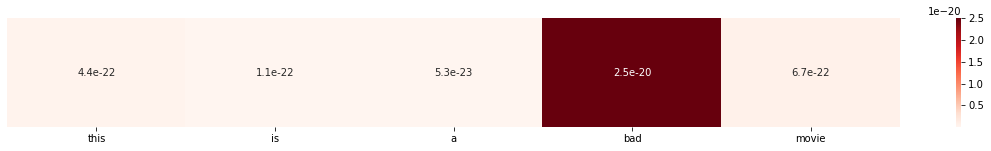

In [39]:
explain_with_gradient('this is a bad movie')

### References

* **EMNLP 2020 Tutorial** on Interpreting Predictions of NLP Models (Eric Wallace, Matt Gardner, Sameer Singh)
    * https://www.youtube.com/watch?v=gprIzglUW1s&t=3384s 
* **NeurIPS 2020 Tutorial** on Explaining ML Predictions: State-of-the-art, Challenges, and Opportunities (Himabindu Lakkaraju, Julius Adebayo, Sameer Singh)
    * https://www.youtube.com/watch?v=EbpU4p_0hes&t=6900s
* A Survey of the State of Explainable AI for Natural Language Processing (Danilevsky et al., 2020)
* A Diagnostic Study of Explainability Techniques for Text Classification (Atanasova et al., 2020)
* Attention is not explanation (Jain and Wallace, 2019)
* Attention is not not explanation (Wiegreffe and Pinter, 2019)
* Neural Machine Translation by Jointly Learning to Align and Translate (Bahdanau et al., 2015)
* Attention Is All You Need (Vaswani et al., 2017)